<a href="https://colab.research.google.com/github/nbkwon/ml-assignment/blob/master/ml_assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# we now need pyplot for plotting data
import matplotlib.pyplot as pyplot
def show_plot(download_file = False):
    pyplot.legend()
    pyplot.show()
    if download_file == False:
       return
    
    import google.colab
    file_name = "test.png"
    pyplot.savefig(file_name)
    google.colab.files.download(file_name)

def make_plot(plot_data_list, use_this = None):
    # it's too samll. make bigger.
    if use_this is None:
        pyplot.figure(figsize=(8, 8))
    else:
        # use_this.set_figheight(8)
        # use_this.set_figwidth(8)
        pass

    for data_dic, plot_type, color, label in plot_data_list:
        if plot_type is "plot":
            if use_this is None:
                pyplot.plot(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)
            else:
                use_this.plot(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)    
        if plot_type is "scatter":
            if use_this is None:
                pyplot.scatter(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)
            else:
                use_this.scatter(list(data_dic.keys()), list(data_dic.values()), c=color, label=label)

10000


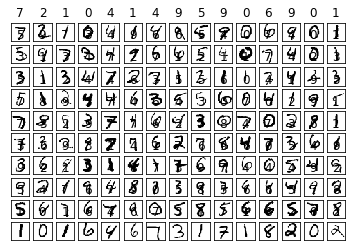

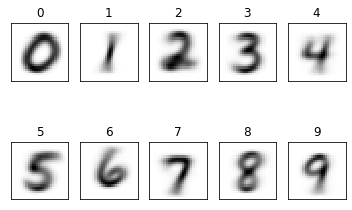

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit, njit, vectorize, cuda
from numpy import arange
import cupy as cp


file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

def normalize(data):
    data_normalized = (data - min(data)) / (max(data) - min(data))
    return(data_normalized)

@jit
def distance(x, y):
    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:
    
    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = int(label)
    list_image[:, count]    = im_vector

    count += 1

list_label_cp = cp.array(list_label)
list_image_cp = cp.array(list_image)

print(count)
#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(str(label))
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()


In [20]:
from functools import reduce

def check_convergence(loss, loss_after):
    # float 형의 자료형 동일한지 판단을 위해 numpy의 isclose를 사용.
    # atol = 0.0000000000000000001
    return abs(np.sum(loss - loss_after)) < 0.000000001
    # return np.isclose(loss, loss_after)
    # return numpy.isclose(theta_list, new_theta_list)


def sigmoid_one(value):
    return 1 / (1 + np.exp(-value))
    
def sigmoid(value):
    r = 1 / (1 + cp.exp(-value))
    return r

def vstack(f):
    bias = cp.ones((1, f.shape[1]))
    return cp.vstack((f, bias))

def npmul(a, b):
    # 2차원에 한해서 dot과 matmul은 동일함.
    return cp.matmul(a,b)

def get_by_mat(mat_list, factor_list):
    result_list = []

    factors = factor_list
    result_list.append(factors)

    # mat 196 x 785
    # mat 784(+1) * 6000
    # -> 196 * 6000 
    for mat in mat_list:
        factors_with_bias = vstack(factors)
     
        factors = npmul(mat, factors_with_bias)
        factors = sigmoid(factors)
        result_list.append(factors)

    
    return result_list

def log(n):
    float_min = 0.00000000000000001
    n[n<float_min] = float_min
    n = cp.log(n)
    
    return n

def get_ret_list(mat_list, f_list):
    ret = get_by_mat(mat_list, f_list)
    return ret

def get_theta_count(mat_list):
    count = 0
    for m in mat_list:
        count += m.shape[0] * m.shape[1]
    return count

def calc_energy_value(mat_list, f_list, d_list, ret_list, lamb):
    #d_list = [0 0 0 0 1 0 0 0 0 0]
    #ret_list = [[0....0]
    # for r_in_d, ret in zip(d_list, ret_list[-1]):
    ret = ret_list[-1]
    # print(d_list[0], ret[0])
    # print((1 - d_list) * log(1 - ret))
    calculated = -d_list * log(ret) - (1 - d_list) * log(1 - ret)
    calculated /= d_list.shape[1]

    loss = cp.sum(calculated)
    theta_loss = 0
    for m in mat_list:
        theta_loss += cp.sum(m ** 2)

    theta_loss *= (lamb / (2 * get_theta_count(mat_list)))
    # return calculated
    # print(calculated)

    return loss + theta_loss

def calc_next_gradient(lr, mat_list, f_list, d_list, ret_list, lamb):
    h_list = ret_list[-1]
    calculated_error = (h_list - d_list) 
    #     calculated_error = (-d_list/h_list) + (1-d_list) * (1 / (1 - h_list)
    # calculated_error *= h_list * (1 - h_list )  

    error_list = calculated_error  / d_list.shape[1]

    new_mat_list = []
    theta_count = get_theta_count(mat_list)

    for i in range(len(mat_list)-1, -1, -1):
        now_mat = mat_list[i]
        new_mat = now_mat.copy()

        factor_with_bias = vstack(ret_list[i])
        # print(factor_with_bias.shape)
        # print(error_list.shape)
        calced = lr * (npmul(error_list,factor_with_bias.transpose()) + (lamb / theta_count) * now_mat)
        # print("new_mat calced", new_mat.shape, calced.shape)
        new_mat -= calced

        new_mat_list.append(new_mat)

        # error_list 갱신. 레이어의 에러를 미리 계산하는거라서 끝난상황이면 갱신할 필요가 없다.
        if(i - 1 < 0):
            continue
        
        v = ret_list[i]
        v = v * (1 - v)
        a = cp.dot(now_mat.transpose(), error_list)
        # print("check dLdz dzdz(i-1) (i)", v.shape, factor_with_bias.shape)
        
        # 49 * 60 -> 50 * 60
        new_error_list = v * a[:-1, ]
        # print("new error_list", new_error_list.shape)
        error_list = new_error_list
    
    # print("new_mat_list len", len(new_mat_list))
    new_mat_list.reverse()

    return new_mat_list

def calc_accuracy(ret_list, answer_list):
    calculated = cp.argmax(ret_list[-1][:, ], axis=0)
    answer = cp.argmax(answer_list[:, ], axis=0)
    corrected = cp.sum(calculated == answer)
    
    count = answer_list.shape[1]

    # print("accuracy count", count)
    # print(calculated)
    # print(answer)       
    # print(corrected)

    return  corrected / count

# r = np.zeros(10, dtype=cp.float64)
# r[0] = 1
# d_dict = [(d, r)]
# print(calc_energy_value([x_to_y_matrix, y_to_z_matrix, z_to_h_matrix], d_dict))
# @njit
def to_label_list(x):
    l = np.zeros(10, dtype=cp.float64)
    l[x] = 1
    return l

# print(list_label)

def make_thetas(x, y):
    a = cp.random.normal(0, 1, x * y).reshape(x,y)
    # a = cp.ones(x * y).reshape(x,y) * 0.0001
    return a



cut = 10000
# cut = 100
list_label = list_label_cp[:cut]
list_image = list_image_cp[:, :cut]
ti = 1000 #train index
# ti = 60 #train index
driver = lambda x: to_label_list(x)
train_list_label_arranged = cp.asnumpy(list_label[:ti])
train_list_label_arranged = cp.array(list(map(driver, train_list_label_arranged))).transpose()
test_list_label_arranged = cp.asnumpy(list_label[ti:])
test_list_label_arranged = cp.array(list(map(driver, test_list_label_arranged))).transpose()

train_image = list_image[:, :ti]
test_image = list_image[:, ti:]



x_to_y_matrix = make_thetas(100, 785)
# y_to_z_matrix = make_thetas(49, 197)
z_to_h_matrix = make_thetas(10, 101)
mats = []
node_list = [128,128]

def make_mat_list(node_list):
    mat_list = []

    pre = 784
    for node in node_list:
        nex = node 
        mat_list.append(make_thetas(nex, pre + 1))
        pre = nex
    mat_list.append(make_thetas(10, pre + 1))

    return mat_list

mats = make_mat_list(node_list)


from timeit import default_timer as timer
s = timer()
lr = 1.693922
lamb = 200

# test value
# lr = 0.6
# lamb = 0.01

max_acc = 0

while True:
    import random
    
    node_list = []
    layer_num = random.randint(1,3)
    for i in range(layer_num):
        node_list.append(random.randint(50, int(500 / layer_num)))
    
    mat_seed = layer_num = random.randint(1,100)

    np.random.seed(mat_seed)
    mats = make_mat_list(node_list)

    lamb = random.random() * 150

    step_count = 0
    
    stpcnt_train_costs = {}
    stpcnt_test_costs = {}

    stpcnt_train_accuracy = {}
    stpcnt_test_accuracy = {}

    stpcnt_mats = {}

    node_list = [151, 67, 130]
    np.random.seed(48)
    mats = make_mat_list(node_list)
    lamb = 15.976865992260498

    max_acc = 0

    while True:
        train_ret_list = get_ret_list(mats, train_image)
        train_cost = calc_energy_value(mats, train_image, train_list_label_arranged, train_ret_list, lamb)

        test_ret_list = get_ret_list(mats, test_image)
        test_cost = calc_energy_value(mats, test_image, test_list_label_arranged, test_ret_list, lamb)

        stpcnt_train_costs[step_count] = float(train_cost)
        stpcnt_test_costs[step_count] = float(test_cost)
        # stpcnt_mats[step_count] = mats
        stpcnt_train_accuracy[step_count] = calc_accuracy(train_ret_list, train_list_label_arranged)
        stpcnt_test_accuracy[step_count] = calc_accuracy(test_ret_list, test_list_label_arranged)
        # print("middle")
        
        
        new_lr = lr
        
        # if step_count > 300000:
        #     new_lr = lr / np.sqrt(step_count)
        # if step_count > 2:
        #     cost_delta = abs(stpcnt_train_costs[step_count-1] - stpcnt_train_costs[step_count])
        #     new_lr = lr * min(10, np.sqrt(( 1 / cost_delta)))

        if step_count % 500 == 499:
            # print(f"[{step_count}]", end='')
            print("loop", step_count, "accu", stpcnt_train_accuracy[step_count], stpcnt_test_accuracy[step_count], "loss", stpcnt_train_costs[step_count], stpcnt_test_costs[step_count])
            # print("{0:.16f}".format(new_lr))
            print(f"max acc refresh. {max_acc} step_count{step_count}")
            pass
        
        # if step_count % 1000 == 999:
        #     mempool = cp.get_default_memory_pool()
        #     # print("clear memory pool")
        #     # print("used, total", mempool.used_bytes(), mempool.total_bytes())
        #     mempool.free_all_blocks()
        #     # print("used, total", mempool.used_bytes(), mempool.total_bytes())

        if stpcnt_test_accuracy[step_count] > 0.9:
            lr = 0.00000001
        elif stpcnt_test_accuracy[step_count] > 0.896:
            lr = 0.000001

        acc = stpcnt_test_accuracy[step_count]
        if max_acc < acc:
            max_acc = acc

        # if step_count > 10000:
        #     break

        new_mats = calc_next_gradient(new_lr, mats, list_image, train_list_label_arranged, train_ret_list, lamb)
        mats = new_mats

        if (step_count > 2 and check_convergence(stpcnt_train_costs[step_count-1], stpcnt_train_costs[step_count])):
            break

        step_count = step_count + 1
    
    break
    # acc = stpcnt_test_accuracy[step_count]
    # if max_acc < acc:
    #     print(f"max acc refresh. {acc} node_list{node_list} lamb{lamb} seed{mat_seed} step_count{step_count}")
    #     max_acc = acc
    # else:
        # print(f"acc tried. {acc} node_list{node_list} lamb{lamb}")
    



e = timer()
print("소요시간", e - s)
print(list(stpcnt_train_costs.values()))
print(list(stpcnt_test_costs.values()))

# 50 ~ ~ 60


loop 499 accu 1.0 0.7956666666666666 loss 6.654019275938478 7.993344079130596
max acc refresh. 0.7955555555555556 step_count499
loop 999 accu 1.0 0.8125555555555556 loss 5.475474043498452 6.801113904192757
max acc refresh. 0.8126666666666666 step_count999
loop 1499 accu 1.0 0.8273333333333334 loss 4.516469422866929 5.774073689908933
max acc refresh. 0.8273333333333334 step_count1499
loop 1999 accu 1.0 0.8383333333333334 loss 3.7283510617747853 4.90917614540069
max acc refresh. 0.8384444444444444 step_count1999
loop 2499 accu 1.0 0.8463333333333334 loss 3.0803228093436092 4.187109061402618
max acc refresh. 0.8463333333333334 step_count2499
loop 2999 accu 1.0 0.8576666666666667 loss 2.547403540313474 3.5875206916719766
max acc refresh. 0.8576666666666667 step_count2999
loop 3499 accu 1.0 0.8633333333333333 loss 2.10916252460487 3.089499922595113
max acc refresh. 0.8633333333333333 step_count3499
loop 3999 accu 1.0 0.8692222222222222 loss 1.7487664995224597 2.6768307518873513
max acc refr

In [0]:
def get_10_data(ret_list, answer_list, get_correct):
    ret_list = cp.asnumpy(ret_list)
    for i, l in enumerate(ret_list):
        ret_list[i] = cp.asnumpy(l)

    answer_list = cp.asnumpy(answer_list)
    list_image  = np.empty((size_row * size_col, 10), dtype=float)
    list_label  = np.empty(10, dtype=int)


    print(answer_list.shape)
    i = 0
    for idx in range(answer_list.shape[1]):
        if i >= 10: 
            break

        output_ret = ret_list[-1]
        # print(ret_list)

        calculated = np.argmax(ret_list[-1][:, idx], axis=0)
        answer_get = np.argmax(answer_list[:, idx], axis=0)
        corrected = calculated == answer_get

        # print("c", calculated)
        # print("a", answer_get)
        # print("c", corrected)
        if corrected == get_correct:
            # print(ret_list)
            list_image[:, i] = ret_list[0][:, idx]
            list_label[i] = calculated
            i = i + 1

    return list_image, list_label

good_tuple = get_10_data(train_ret_list, train_list_label_arranged, True)
bad_tuple = get_10_data(test_ret_list, test_list_label_arranged, False)

(10, 1000)
(10, 9000)


In [0]:
def show_classification_example(good_tuple, bad_tuple):
    print("upper : good classification from train data")
    print("under : bad classification from test data")
    f1 = plt.figure(1)

    images, labels = good_tuple
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.title(labels[i])
        plt.imshow(images[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

        frame   = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)

    f2 = plt.figure(2)

    images, labels = bad_tuple
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.title(labels[i])
        plt.imshow(images[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

        frame   = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)


    plt.show()

1. Plot the loss curve

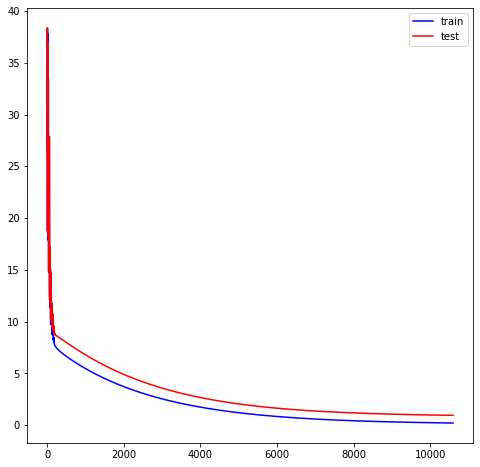

In [21]:
make_plot([(stpcnt_train_costs, "plot", "blue", "train"), (stpcnt_test_costs, "plot", "red", "test") ])
show_plot()

2. Plot the accuracy curve

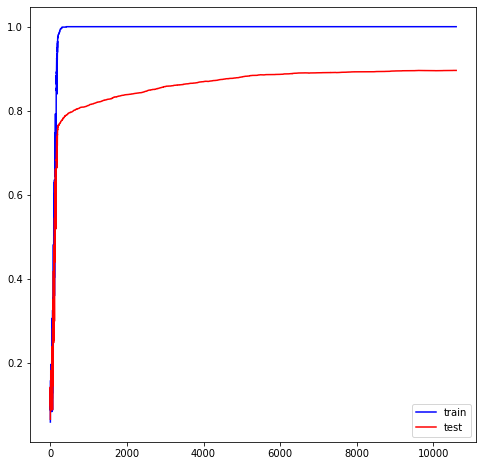

In [22]:
make_plot([(stpcnt_train_accuracy, "plot", "blue", "train"), (stpcnt_test_accuracy, "plot", "red", "test") ])

show_plot()

3. Plot the accuracy value

In [23]:
def get_last(d):
    return d[list(d.keys())[-1]]

print(f"train accuracy: {get_last(stpcnt_train_accuracy) * 100}%")
print(f"test accuracy: {get_last(stpcnt_test_accuracy) * 100}%")

train accuracy: 100.0%
test accuracy: 89.60000000000001%


4. Plot the classification example

upper : good classification from train data
under : bad classification from test data


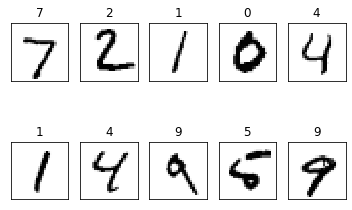

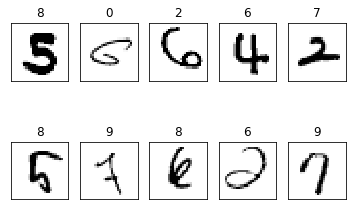

In [24]:
show_classification_example(good_tuple, bad_tuple)
